# GroundedDINO Utilities Demo
This notebook shows how to use the `grounded_sam_utils.py` utilities to:
1. Load the GroundingDINO model.
2. Load experiment metadata and images.
3. Run inference on a sample image.
4. Add and save annotations (prompt and model config) to a JSON store.
5. Retrieve and visualize stored annotations.

In [1]:
# Cell 1: Setup and Imports
import os, sys
from pathlib import Path
import torch
# add project path
SANDBOX_ROOT = Path("/net/trapnell/vol1/home/mdcolon/proj/morphseq/segmentation_sandbox")
sys.path.append(str(SANDBOX_ROOT))
from scripts.utils.grounded_sam_utils import (load_config, load_groundingdino_model, GroundedDinoAnnotations, gdino_inference_with_visualization, run_inference, visualize_detections)
from scripts.utils.experiment_metadata_utils import load_experiment_metadata, get_image_id_paths
print("✅ Imports successful. PyTorch: %s, CUDA: %s" % (torch.__version__, torch.cuda.is_available()))

✅ Imports successful. PyTorch: 2.5.1, CUDA: True


In [2]:
# Cell 2: Load Config, Metadata, Model, Manager
config = load_config(SANDBOX_ROOT/"configs"/"pipeline_config.yaml")

exper_metadata = load_experiment_metadata(SANDBOX_ROOT/"data"/"raw_data_organized"/"experiment_metadata.json")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#load the model
model = load_groundingdino_model(config, device=device)

gdino_anno_path = SANDBOX_ROOT/"data"/"annotation_and_masks"/"gdino_annotations.json"

gdino_anno_obj = GroundedDinoAnnotations(gdino_anno_path, exper_metadata)

print("✅ Model and annotation manager ready.")

final text_encoder_type: bert-base-uncased
GroundedDINO model loaded successfully on cuda.
🆕 Initializing new annotations file at: /net/trapnell/vol1/home/mdcolon/proj/morphseq/segmentation_sandbox/data/annotation_and_masks/gdino_annotations.json
✅ Model and annotation manager ready.


In [ ]:
# Cell 3: Run Inference & Add Annotation
img_id = exper_metadata['image_ids'][0]  # pick first image

img_path = get_image_id_paths(img_id, exper_metadata)

prompt = 'zebrafish embryo'
boxes, logits, phrases, img_src = run_inference(model, img_path, prompt)

# Get actual file paths from image IDs


In [ ]:

import numpy as np
from typing import Dict, List, Tuple, Optional, Union
import cv2
import matplotlib.pyplot as plt
def visualize_detections(image_source: np.ndarray, boxes: torch.Tensor, logits: torch.Tensor, 
                         phrases: List[str], title: str = "Detections", save_path: Optional[str] = None):
    """Visualize detections on an image with improved annotation display."""
    annotated_frame = image_source.copy()
    h, w, _ = annotated_frame.shape
    
    # Define colors for different detections
    colors = [
        (0, 100, 200),    # Dark Red
        (0, 80, 160),     # Dark Orange  
        (20, 120, 20),    # Dark Green
        (150, 50, 0),     # Dark Blue
        (120, 20, 120),   # Dark Purple
        (0, 140, 140),    # Dark Yellow/Brown
        (100, 0, 100),    # Dark Magenta
        (80, 80, 0),      # Dark Cyan
        (60, 20, 140),    # Dark Red-Purple
        (0, 60, 100),     # Dark Orange-Red
        (40, 100, 0),     # Dark Blue-Green
        (100, 60, 20),    # Dark Blue-Purple
    ]
    
    for i, (box, logit, phrase) in enumerate(zip(boxes, logits, phrases)):
        # Convert normalized coordinates to pixel coordinates
        if isinstance(box, torch.Tensor):
            box_norm = box.clone()
        else:
            box_norm = torch.tensor(box)
            
        # Convert from center format to corner format
        cx, cy, bw, bh = box_norm
        x1 = int((cx - bw/2) * w)
        y1 = int((cy - bh/2) * h)
        x2 = int((cx + bw/2) * w)
        y2 = int((cy + bh/2) * h)
        
        # Choose color
        color = colors[i % len(colors)]
        
        # Draw bounding box
        cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), color, 2)
        
        # Prepare label with confidence
        confidence = float(logit) if isinstance(logit, torch.Tensor) else logit
        label = f"{phrase}: {confidence:.2f}"
        
        # Get text size for background
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale =  2
        thickness = 10
        (text_width, text_height), baseline = cv2.getTextSize(label, font, font_scale, thickness)
        
        # Draw label background
        cv2.rectangle(annotated_frame, 
                      (x1, y1 - text_height - 10), 
                      (x1 + text_width, y1), 
                      color, -1)
        
        # Draw label text
        cv2.putText(annotated_frame, label, 
                   (x1, y1 - 5), font, font_scale, (255, 255, 255), thickness)

    # Display
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=150)
        print(f"Visualization saved to: {save_path}")
    
    plt.show()




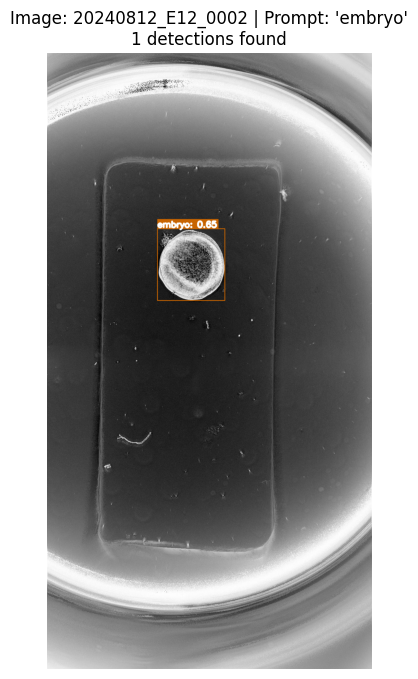

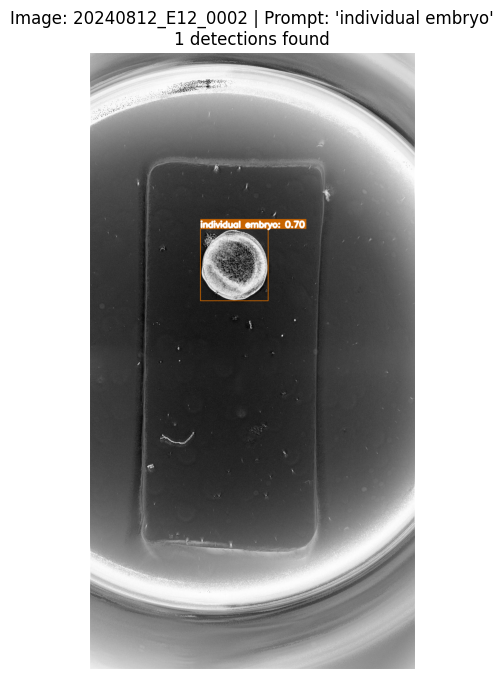

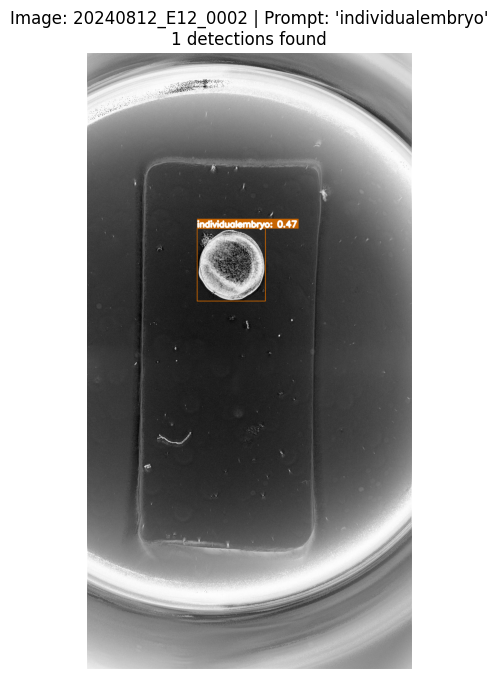

In [ ]:
# Cell 3: Run Inference & Add Annotation
img_id = exper_metadata['image_ids'][2]  # pick third image

img_path = get_image_id_paths(img_id, exper_metadata)
prompt = ["embryo", 'individual embryo', "individual_embryo"]

results = gdino_inference_with_visualization(
    model,
    img_path,
    prompt,
    box_threshold=0.35, 
    text_threshold=0.25,
    show_anno=True,  # Set to False to only save images
    verbose=False,
    # save_dir=embroid_output_path,
    text_size=.5
)


In [ ]:
import glob
embroid_paths = get_jpg_files("/net/trapnell/vol1/home/mdcolon/proj/morphseq/segmentation_sandbox/data/embryoid_images/raw")
embroid_output_path = "/net/trapnell/vol1/home/mdcolon/proj/morphseq/segmentation_sandbox/data/embryoid_images/processed"

results = gdino_inference_with_visualization(
    model, 
    embroid_paths, 
    prompts=["dark blob", "embryoid", "embryoid body", "embryoid bodies", "embryoid body (dark blob)"],
    box_threshold=0.35, 
    text_threshold=0.25,
    show_anno=False,  # Set to False to only save images
    verbose=False,
    save_dir=embroid_output_path,
    text_size=.5
)


📁 Found 4 JPG files in /net/trapnell/vol1/home/mdcolon/proj/morphseq/segmentation_sandbox/data/embryoid_images/raw
   🔄 (searched recursively)
   📝 First few files: ['20240527gas008zlplate4_s6_a1_p1_t0-60_bf.t055 (1).jpeg', '20240527gas008zlplate4_s6_a2_p1_t0-60_bf.t033 (1).jpeg', '20240527gas008zlplate4_s6_a4_p1_t0-60_bf.t049 (1).jpeg']...


In [ ]:
# Cell 4: Retrieve & Visualize Annotations
anns = manager.get_annotations_for_image(img_id)
print(f'Retrieved {len(anns)} annotation sets for {img_id}')
# visualize first set
entry = anns[0]
boxes_st = torch.tensor([d['box_xywh'] for d in entry['detections']])
logits_st = torch.tensor([d['confidence'] for d in entry['detections']])
phrases_st = [d['phrase'] for d in entry['detections']]
visualize_detections(img_src, boxes_st, logits_st, phrases_st, title=f"{img_id} - {entry['prompt']}")

NameError: name 'manager' is not defined

**Demo Complete**: You have loaded the model, run inference with a prompt, saved annotations, and visualized results.